In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch
from mplsoccer.pitch import VerticalPitch
import seaborn as sns
import matplotlib as mpl
from scipy.ndimage import gaussian_filter
from highlight_text import fig_text

#Read in the data
df = pd.read_csv('Footballdata/New/SouthamptonvsManUtd.csv', encoding='latin-1')

"""
#df = df.loc[df['period/displayName'] == 'FirstHalf']

#Make a new, single column for time and sort the events in chronological order
df["newsecond"] = 60*df["minute"]+df["second"]

df = df.loc[df['newsecond'] < 3236]
"""

#Adjust for pitch size
df['x'] = df['x']*1.2
df['y'] = df['y']*.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*.8

#Filter for points beyound the half-way point and excludes corners and throw ins
df = df.loc[(df['x'].between(59.9,119.3)) &
            (df['y'].between(0.5,79.9))]

#Create new varaible to find out if the touch or pass occured in the final 3rd
df['f3rd_touch']=np.where((df['x']>= 80) & 
                         ((df['isTouch']== True) | 
                         ((df['type/displayName']=='Pass') & df['outcomeType/displayName'] == 'Successful')), 1, 0)

#Identify teams
t = []
for i in df.teamId.unique():
    t.append(i)

home = t[0]
away = t[1]

#Split them into the two teams
dfhome = df[df['teamId']== home]
dfaway = df[df['teamId']== away]

#Sum of touches from both teams in the final 3rd, and identify the percentage
dt_h_tot = dfhome['f3rd_touch'].sum()
dt_a_tot = dfaway['f3rd_touch'].sum()
h_tilt_p = round(dt_h_tot/(dt_h_tot+dt_a_tot)*100,2)
a_tilt_p = round(dt_a_tot/(dt_h_tot+dt_a_tot)*100,2)

#Turn them into strings
h_tilt_p=str(h_tilt_p)
a_tilt_p=str(a_tilt_p)

#Filter for final 3rd touches for the home team
dfhome = dfhome[dfhome['f3rd_touch'] == 1]

#Need home team to be displayed on the left, so need to find the absolute values
dfhome['x'] = dfhome['x']-120
dfhome['y'] = dfhome['y']-80
dfhome['x'] = dfhome['x'].abs()
dfhome['y'] = dfhome['y'].abs()

#Filter for final 3rd touches for the away team
dfaway = dfaway[dfaway['f3rd_touch'] == 1]

home

'Southampton'

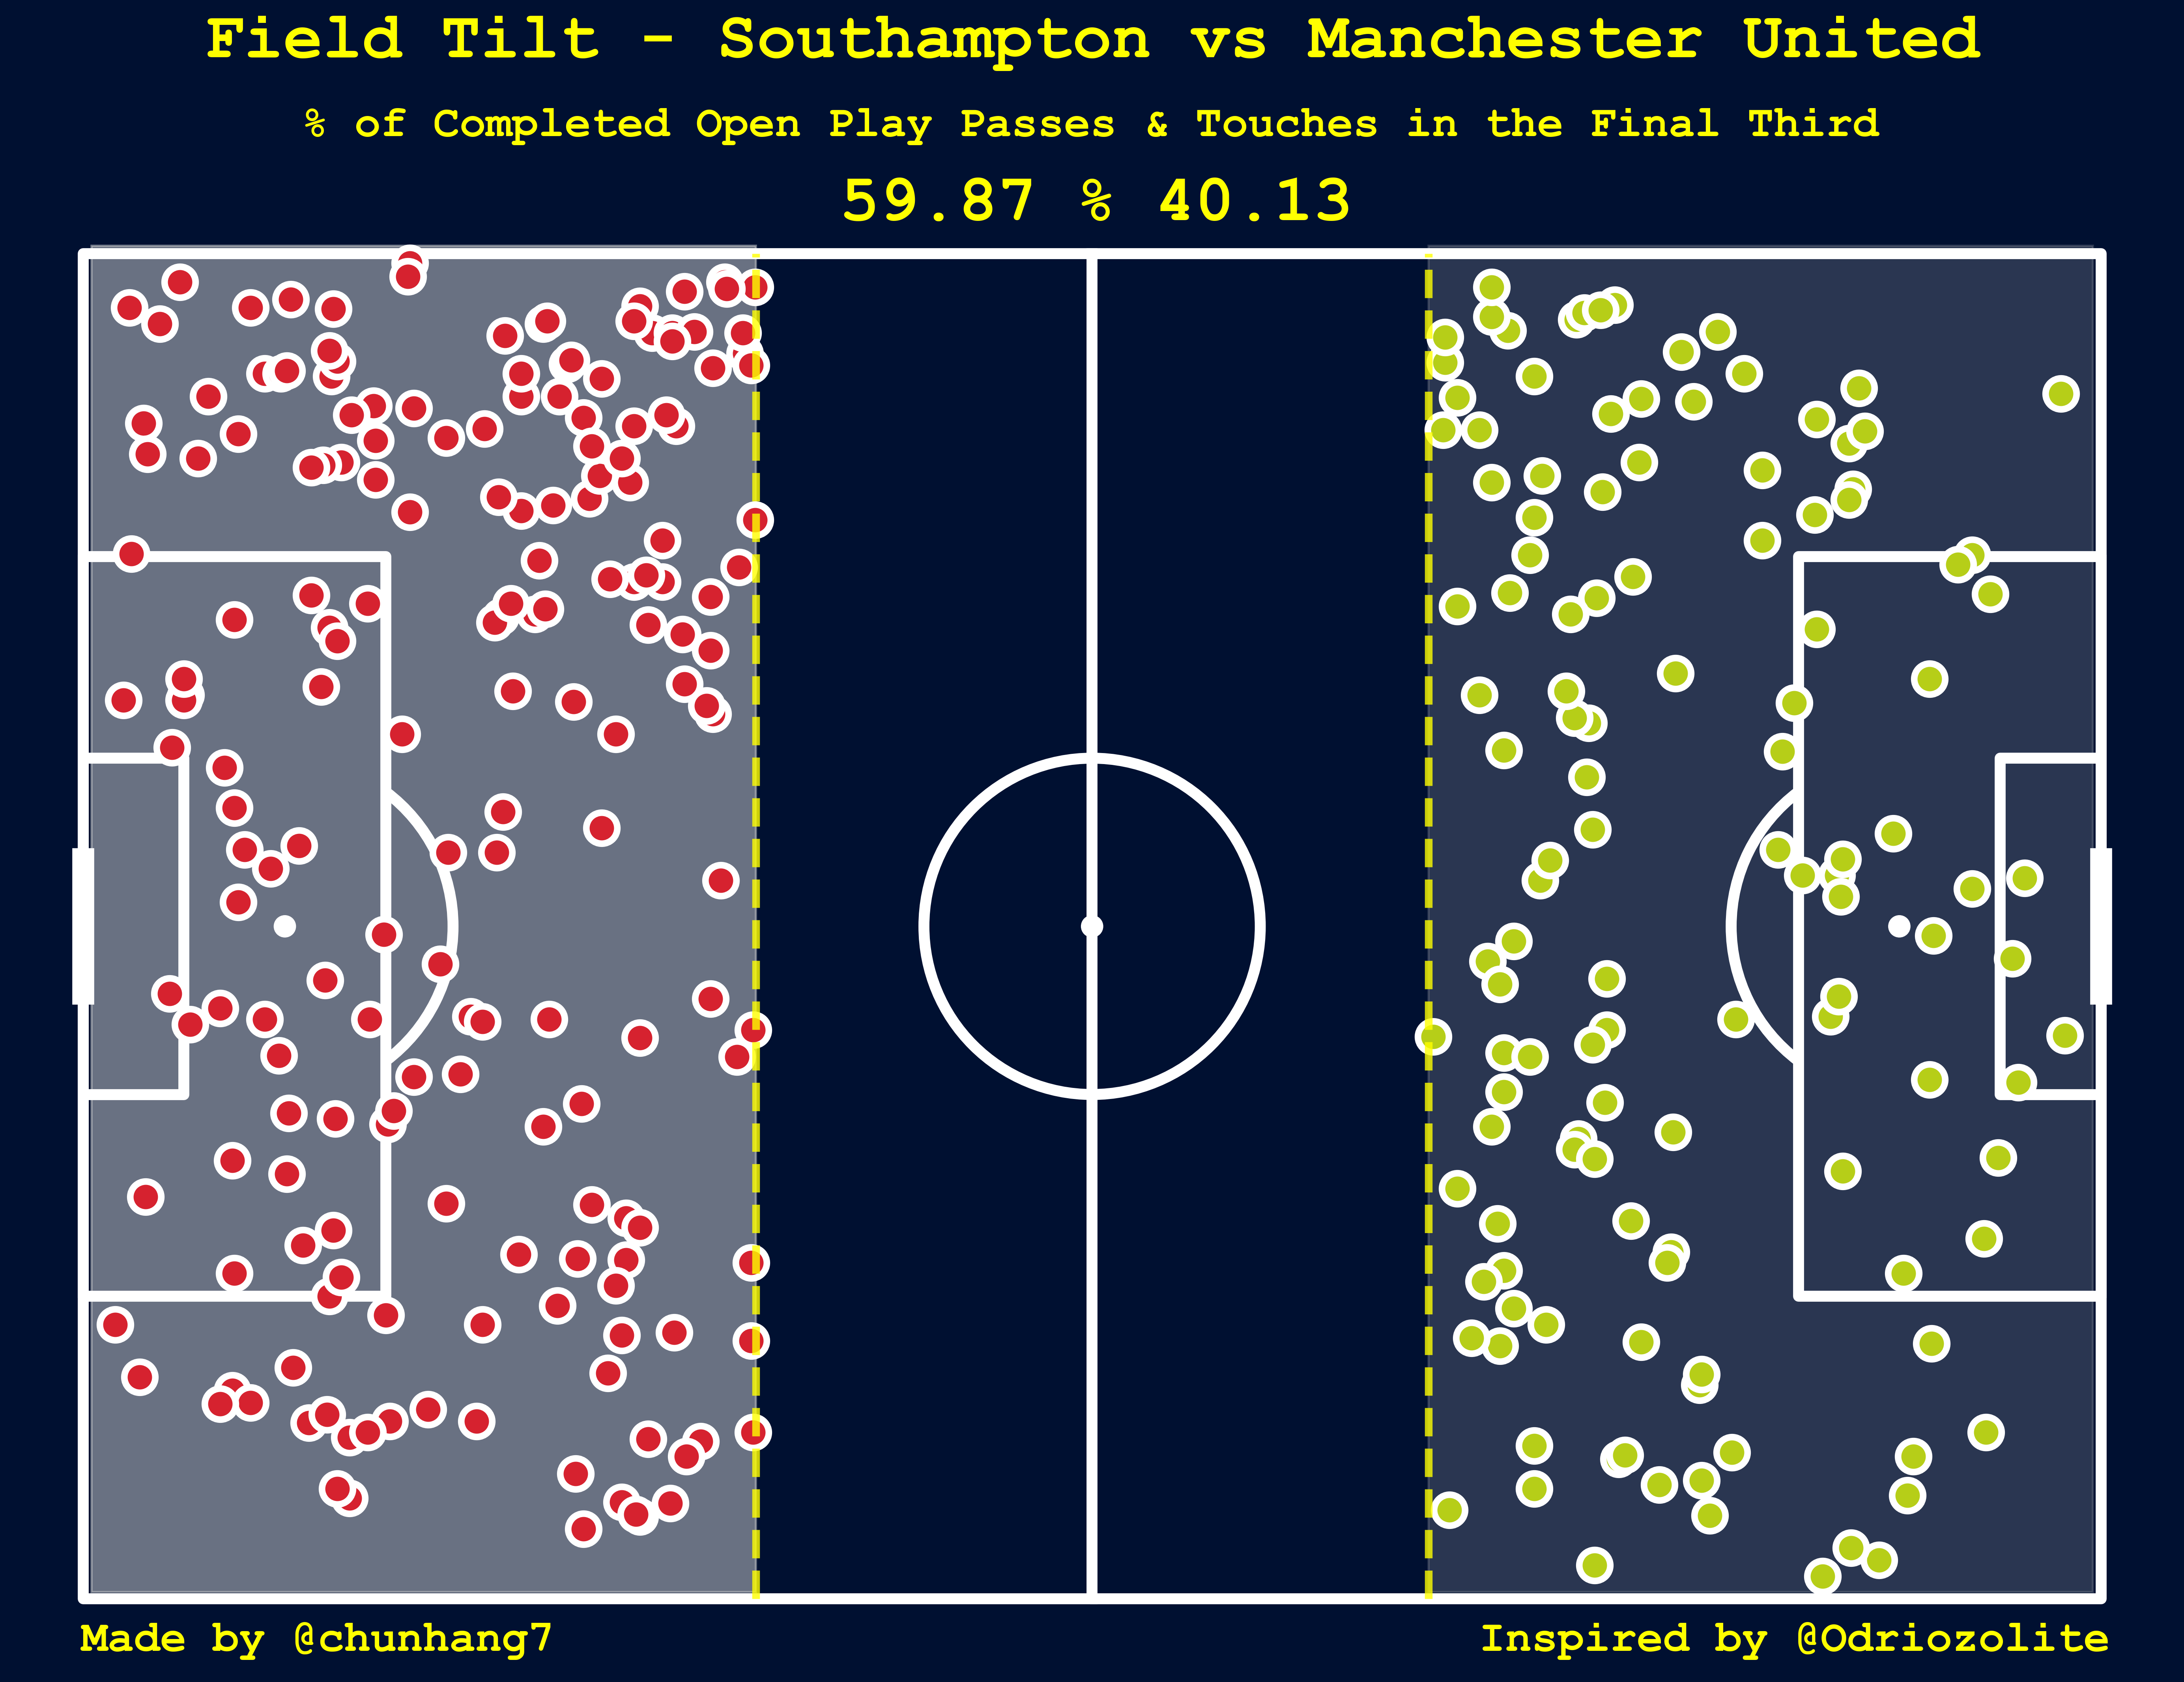

In [17]:
#Set color
homecolor = '#d6222f'
awaycolor = '#b6ce18'

#Make the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#001031', line_color='white',linewidth=5, spot_scale=0.005)
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#001031')

#inverse y-axis
plt.gca().invert_yaxis()

#plot the pass locations for home side
plt.scatter(dfhome.x, dfhome.y, marker='o', s=200, c=homecolor, 
            linewidth = 3, edgecolor='w')

#plot the pass locations for away side
plt.scatter(dfaway.x, dfaway.y, marker='o', s=200, c=awaycolor, 
          linewidth = 3, edgecolor='w')

#Draw line
ax.plot([80,80], [0, 80], c='yellow', lw=3.5, ls='--', zorder=9, alpha=0.8)

ax.plot([40,40], [0, 80], c='yellow', lw=3.5, ls='--', zorder=9, alpha=0.8)

#shade
plt.axvspan(80,119.5,ymin=0.05,ymax=0.96,color='lightgrey',zorder=-1,alpha=0.2)

plt.axvspan(0.5,40,ymin=0.05,ymax=0.96,color='lightgrey',zorder=-1,alpha=0.5)

#Annotations
plt.title("Field Tilt - " + home +" vs " + away+"\n",color='yellow',size=30, 
          fontfamily = "Courier New", fontweight = "bold",pad=30)

ax.text(13,87, '% of Completed Open Play Passes & Touches in the Final Third', fontsize=20, 
       color='yellow',fontweight = "bold",fontfamily = "Courier New")

ax.text(45,82, h_tilt_p + ' % ' + a_tilt_p, fontsize=30, 
       color='yellow',fontweight = "bold",fontfamily = "Courier New")

ax.text(-0.1, -2.5, 'Made by @chunhang7', va='center', ha='left', fontsize=20, color='yellow',
        fontweight = "bold",fontfamily = "Courier New")

ax.text(83, -2.5, 'Inspired by @Odriozolite', va='center', ha='left', fontsize=20, color='yellow',
        fontweight = "bold",fontfamily = "Courier New")

plt.show()

In [18]:
a_dt = [0]
h_dt= [0]
a_min = [0]
h_min = [0]
a_tilt = [0]
h_tilt= [0]
home_goals_list = [0]
away_goals_list = [0]
minute=[0]
goalmin_h=[]
goalmin_a=[]

strt_min= df['minute'].min()
end_min=df['minute'].max()

In [19]:
#New dataframes for the goals, deep touches and minutes 
#goal_h = dfhomem[(dfhomem['type/displayName'] == 'Goal')].sum()

for x in range(strt_min,end_min):
    #For every minute, calculate final third touches and append to a list
    dfhomem= dfhome[dfhome['minute']==x]
    deeptouch_h = dfhomem['f3rd_touch'].sum()
    h_dt.append(deeptouch_h)
    
    #For every minute, calculate goals and append to a list
    goal_h = dfhomem['isGoal'].sum()
    h_min.append(x)

    #For every minute, calculate final third touches and append to a list
    dfawaym= dfaway[dfaway['minute']==x]    
    deeptouch_a = dfawaym['f3rd_touch'].sum()
    a_dt.append(deeptouch_a)

    #For every minute, calculate goals and append to a list
    goal_a = dfawaym['isGoal'].sum()
    a_min.append(x)
    
    away_goals_list.append(goal_a)
    home_goals_list.append(goal_h)
    
    if goal_a > 0:
        goalmin_a.append(x)
    elif goal_h > 0:
        goalmin_h.append(x)

In [20]:
# Everything in a df and calculate the rolling average
df_hg = pd.DataFrame({'Goal':goalmin_h,"Value": 0})
df_ag = pd.DataFrame({'Goal':goalmin_a,"Value": 0})
df_dt = pd.DataFrame({'Minute':a_min,"Home Deep Touch": h_dt, 'Away Deep Touch': a_dt})

window1 = 10

df_dt['dt_h_MA'] = df_dt['Home Deep Touch'].rolling(window=window1).mean()
df_dt['dt_a_MA'] = df_dt['Away Deep Touch'].rolling(window=window1).mean()

df_dt['Tilt']=(df_dt['dt_h_MA']/(df_dt['dt_h_MA']+df_dt['dt_a_MA']))-0.5
df_dt['Tilt1']=gaussian_filter(df_dt['Tilt'],1)
window1=str(window1)

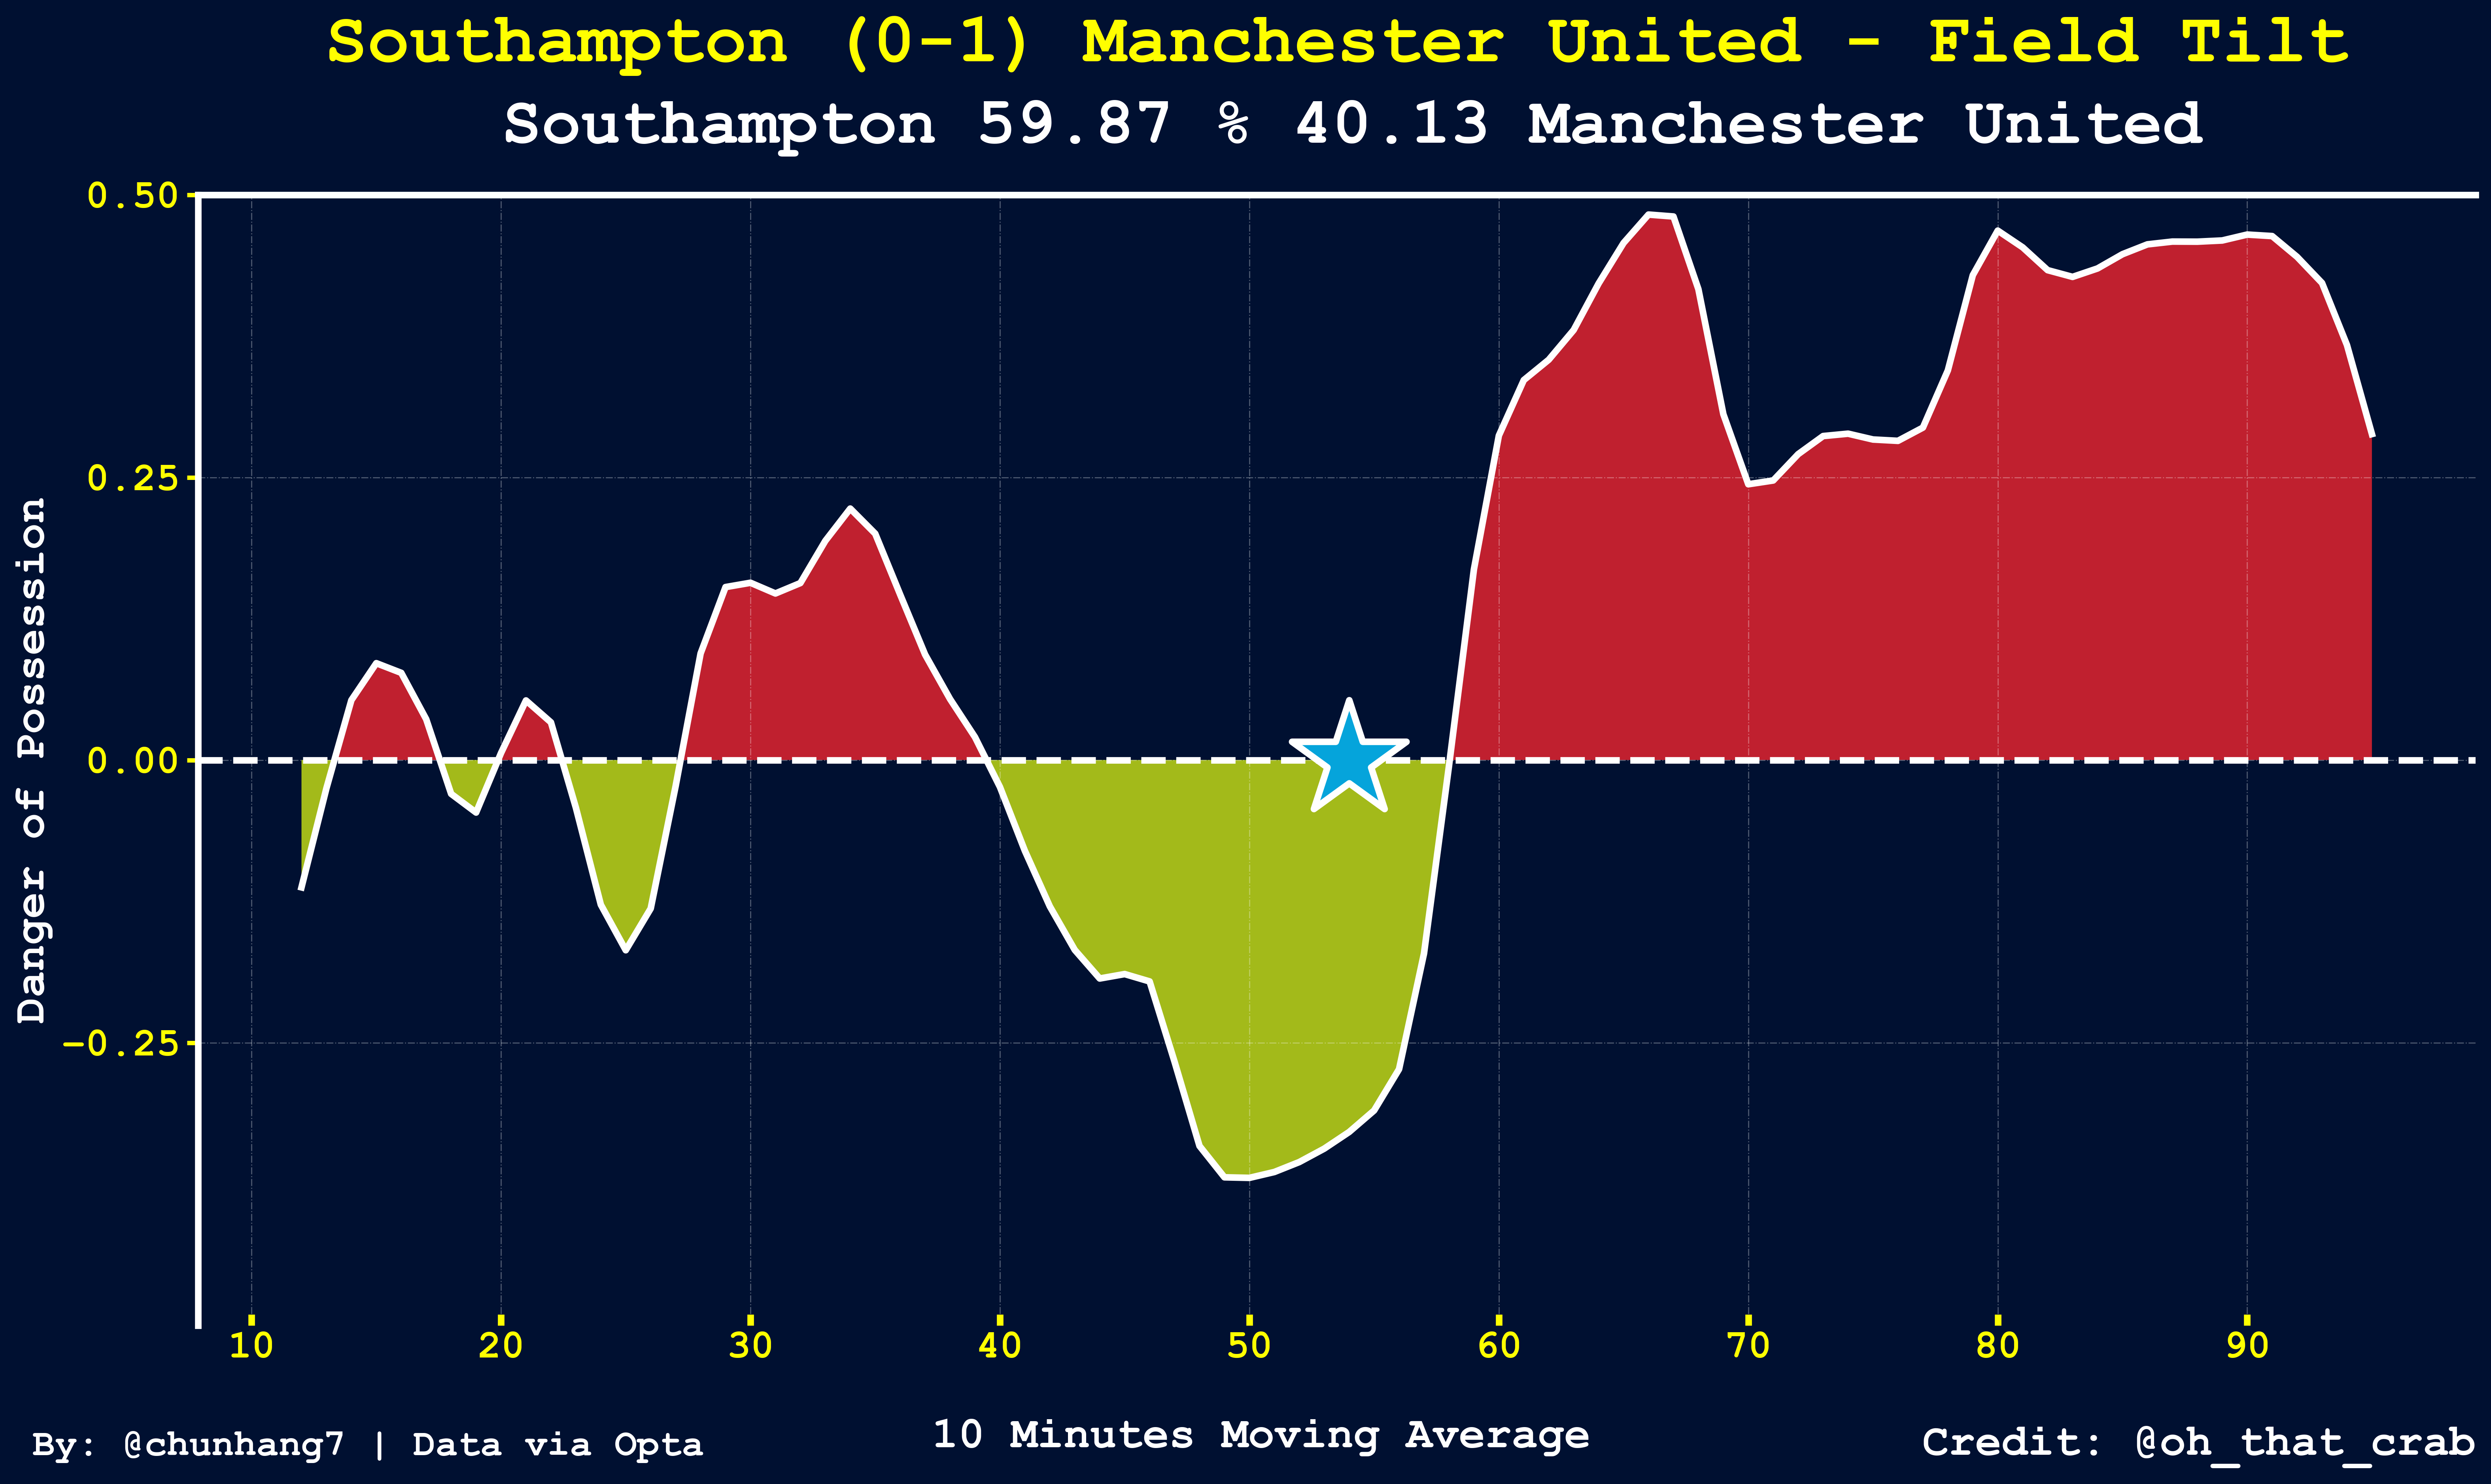

In [46]:
#make the plot
fig, ax = plt.subplots(figsize=(16,11))
fig.set_facecolor('#001031')
mpl.rcParams['figure.dpi'] = 400

#background color
ax.patch.set_facecolor('#001031')

#set up our base layer
mpl.rcParams['xtick.color'] = 'yellow'
mpl.rcParams['ytick.color'] = 'yellow'

#setting up the grid
ax.grid(ls='-.', lw=.5, color='white', axis='y', zorder=0, alpha=0.3)
ax.grid(ls='-.', lw=.5, color='white', axis='x', zorder=0, alpha=0.3)

#Setting up the spine
spines = ['bottom','right']
for x in spines:
    if x in spines:
        ax.spines[x].set_visible(False)
        
#Set spine width & color
ax.spines['left'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['left'].set_color('white')
ax.spines['top'].set_color('white')

#set the ticks
ax.set_xticks([0,10,20,30,40,50,60,70,80,90])
ax.set_yticks([-0.25,0,0.25,0.5,0.75,1])

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=3, width=3,length=5,direction='in')
ax.yaxis.set_tick_params(pad=3, width=2,length=5)

ax.set_ylabel('Danger of Possession',fontname='Courier New',color='white',fontsize=20, fontweight = 'bold')

#Setting Plot fonts
font = {'family' : 'Courier New',
        'weight' : 'bold',
        'size' : 18}
mpl.rc('font', **font)

#Filling
#home
ax.fill_between(df_dt.Minute, df_dt.Tilt1, 0, where=df_dt.Tilt1[0:] >=0, facecolor=homecolor, interpolate=True, alpha=0.9)

#away
ax.fill_between(df_dt.Minute, df_dt.Tilt1, 0, where=df_dt.Tilt1[0:] <=0, facecolor=awaycolor, interpolate=True, alpha=0.9)

ax.axhline(0, color='white', ls='--',lw=3)

#plot the goals
#home
ax.scatter(x=df_hg['Goal'],y=df_hg['Value'],marker='*',s=2000, color='yellow', zorder=3, 
            edgecolors='black',linewidths=3)
#away
ax.scatter(x=df_ag['Goal'],y=df_ag['Value'],marker='*',s=3000, color='#05a4db', zorder=3, 
            edgecolors='w',linewidths=3)

#outline color
ax.plot(df_dt.Minute,df_dt.Tilt1,color='white',lw=3)

#Set limit
ax.set_ylim([-0.5, 0.5])
plt.subplots_adjust(left=0.05,
                    bottom=0.15, 
                    right=0.95, 
                    top=0.8, 
                    wspace=0, 
                    hspace=0.5)

#set title
highlight_text = [{'color': 'w'},
                  {'color': 'w'}]

plt.title(home +" (0-1) "+ away +" - Territorial Dominance\n",color='yellow',size=32, 
          fontfamily = "Courier New", fontweight = "bold",pad=30)

#Annotations
fig.text(x=0.17, y=0.83,
         s=f"{home} {h_tilt_p} % {a_tilt_p} {away}", fontsize=30, 
         color='white', fontweight = 'bold', fontfamily = 'Courier New')


fig.text(0.95, 0.08,'Credit: @oh_that_crab', fontsize=20, color='white',
                                fontweight = 'bold', fontfamily = 'Courier New',
                                ha='right', va='center')

fig.text(0.25, 0.08, 'By: @chunhang7 | Data via Opta', fontsize=17, color='white',
                                fontweight = 'bold', fontfamily = 'Courier New',
                                ha='right', va='center')

fig.text(0.34, 0.08, window1 + ' Minutes Moving Average',
         fontsize=20, color='white', fontweight = 'bold', fontfamily = 'Courier New')

plt.show()